# Image Datasets

> Image datasets

In [2]:
#| default_exp image.datasets

In [3]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [4]:
#| export

import torch
import torch.utils.data as data
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from pytorch_lightning import LightningDataModule

import pandas as pd
from matplotlib import pyplot as plt

from omegaconf import OmegaConf
from hydra.utils import instantiate

from typing import Any, Dict, Optional, Tuple, List


/Users/syl20/mambaforge/envs/nimrod/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ImageDataset base class

In [5]:
#| export
class ImageDataset(Dataset):
    " Base class for image datasets providing visualization of (image, label) samples"

    def show_idx(self,
        index:int # Index of the (image,label) sample to visualize
        ):
        X, y = self.__getitem__(index)
        plt.figure(figsize = (1, 1))
        plt.imshow(X.numpy().reshape(28,28),cmap='gray')
        plt.title(f"Label: {int(y)}")
        plt.show()

    @staticmethod
    def show_grid(imgs, save_path=None):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.detach()
            axs[0, i].imshow(img.numpy().reshape(28,28))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        if save_path:
            plt.savefig(save_path)

    def show_random(self,
        n=3 # number of images to display
        ):
        indices = torch.randint(0,len(self), (n,))
        images = []
        for index in indices:
            X, y = self.__getitem__(index)
            X = X.reshape(28,28)
            images.append(X)
        self.show_grid(images)
        

## MNIST

### MNIST dataset

In [6]:
#| export 

class MNISTDataset(ImageDataset):
    "MNIST digit dataset"

    def __init__(
        self,
        data_dir:str='~/Data', # path where data is saved
        train = True, # train or test dataset
        transform:torchvision.transforms.transforms=torchvision.transforms.ToTensor() # data formatting
    ):

        super().__init__()

        self.ds = MNIST(
            data_dir,
            train = train,
            transform=transform, 
            download=True
        )

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        x = self.ds[idx][0]
        y = self.ds[idx][1]
        return x, y
    
    def train_dev_split(self,
        ratio:float, # percentage of train/dev split,
        seed:int=42 # rand generator seed
    ):
        train_set_size = int(len(self.ds) * ratio)
        valid_set_size = len(self.ds) - train_set_size

        # split the train set into two
        seed = torch.Generator().manual_seed(seed)
        train_set, valid_set = data.random_split(self.ds, [train_set_size, valid_set_size], generator=seed)
        return train_set, valid_set



### Usage
Setup MNIST dataset. Download data if not found in specified location.

Number of samples in the dataset: 10000
torch.Size([1, 28, 28]) 7 torch.FloatTensor


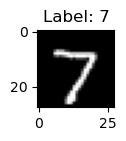

In [7]:
ds = MNISTDataset('~/Data/Image', train=False)
print(f"Number of samples in the dataset: {len(ds)}")
X, y = ds[0]
print(X.shape, y, X.type())
ds.show_idx(0)
train, dev = ds.train_dev_split(0.8)

### Instantiate from config file

In [8]:
# cfg = OmegaConf.load("../config/data/image/mnist.yaml")
# print(cfg.test)
# test_ds = instantiate(cfg.test)
# X, y = test_ds[0]
# test_ds.show_idx(0)


### MNIST DataModule

In [9]:
#| export 

class MNISTDataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str = "~/Data/",
        train_val_test_split:List[float] = [0.8, 0.1, 0.1],
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()
        self.save_hyperparameters(logger=False) # can access inputs with self.hparams
        self.transforms = transforms.Compose([transforms.ToTensor()])
        self.data_train: Optional[Dataset] = None
        self.data_val: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None

        if sum(train_val_test_split) != 1.0:
            raise Exception('split percentages should sum up to 1.0')

    @property
    def num_classes(self):
        return 10

    def prepare_data(self):
        """Download data if needed + format with MNISTDataset
        """
        MNISTDataset(self.hparams.data_dir, train=True)
        MNISTDataset(self.hparams.data_dir, train=False)

    def setup(self, stage: Optional[str] = None):
        if not self.data_train and not self.data_val and not self.data_test:
            trainset = MNISTDataset(self.hparams.data_dir, train=True, transform=self.transforms)
            testset = MNISTDataset(self.hparams.data_dir, train=False, transform=self.transforms)
            dataset = ConcatDataset(datasets=[trainset, testset])
            lengths = [int(split * len(dataset)) for split in self.hparams.train_val_test_split]
            self.data_train, self.data_val, self.data_test = random_split(
                dataset=dataset,
                lengths=lengths,
                generator=torch.Generator().manual_seed(42),
            )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def teardown(self, stage: Optional[str] = None):
        """Clean up after fit or test."""
        pass

    def state_dict(self):
        """Extra things to save to checkpoint."""
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]):
        """Things to do when loading checkpoint."""
        pass


### Usage

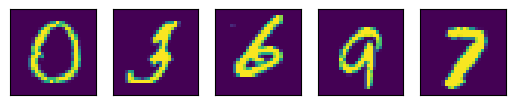

In [12]:
dm = MNISTDataModule(
    data_dir="../data/image",train_val_test_split=[0.8, 0.1, 0.1],
    batch_size = 64,
    num_workers = 0,
    pin_memory= False
)
dm.prepare_data()
dm.setup()
test_dl = dm.test_dataloader()
len(dm.data_test[0])
imgs = [dm.data_test[i][0] for i in range(5)]
ImageDataset.show_grid(imgs)

### Config

{'_target_': 'nimrod.image.datasets.MNISTDataModule', 'data_dir': '../data/image', 'train_val_test_split': [0.8, 0.1, 0.1], 'batch_size': 1024, 'num_workers': 0, 'pin_memory': False}
<class 'nimrod.image.datasets.MNISTDataModule'>


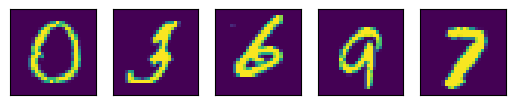

In [13]:
cfg = OmegaConf.load("../config/data/image/mnist.yaml")
print(cfg.datamodule)
dm = instantiate(cfg.datamodule)
dm.prepare_data()
dm.setup()
test_dl = dm.test_dataloader()
len(dm.data_test[0])
imgs = [dm.data_test[i][0] for i in range(5)]
ImageDataset.show_grid(imgs)
print(type(dm))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()